# Map tilt fields for norminal examples of both sources

In [1]:
import pyproj
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import station_positions
import matplotlib
import rasterio
import emcee

import vmod.source
import vmod.data

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Station positions

In [2]:
df, ox, oy = station_positions.station_positions()
stx = df["x"] - ox
sty = df["y"] - oy

## Load model params

In [5]:
sampler = emcee.backends.HDFBackend("./augustineInversion/samples/yang_nish_100nr_nm.h5")
samps = sampler.get_chain(discard=100000, thin=10, flat=True)

## Make same FOV as station maps (minus 1km to help see arrows)

In [6]:
with rasterio.open("./data/topo/augustine_ifsar_hillshade.tif", "r") as src:
    left_aug, bottom_aug, right_aug, top_aug = src.bounds
    hillshade_aug = src.read(1)

pad = 0
xmin = left_aug+12e3-ox-pad
xmax = right_aug-5e3-ox+pad
ymin = bottom_aug+8e3-oy-pad
ymax = top_aug-10.5e3-oy+pad


## Generate tilt fields

In [7]:
# Seismometer Coordinates
url = "https://service.iris.edu/fdsnws/station/1/query?net=AV&sta=AU*&cha=HHE&starttime=2005-11-01&endtime=2006-05-01&level=station&format=text&includecomments=true&nodata=404"
df = pd.read_csv(url, sep="|")

xform = pyproj.Transformer.from_crs("4326", "3338")

sx, sy = xform.transform(df[" Latitude "], df[" Longitude "])

# Fixed coordinate offset (approx top of Augustine)
ox, oy = xform.transform(59.3608498, -153.4298857)

tiltm = vmod.data.tilt.Tilt()
tiltm.set_delta(1)

n = 201
x = np.linspace(xmin, xmax, n)
y = np.linspace(ymin, ymax, n)
gx, gy = np.meshgrid(x, y)
gx = gx.flatten()
gy = gy.flatten()
tiltm.add_xs(gx)
tiltm.add_ys(gy)
tiltm.add_dx(np.zeros_like(gx))
tiltm.add_dy(np.zeros_like(gy))

yang = vmod.source.yang.Yang(tiltm)
nish = vmod.source.nish.Nish(tiltm)

In [8]:
xmed = np.median(samps, axis=0)

eventj = 4

xyang = np.concatenate((xmed[:3], [xmed[10+(eventj*3)]*1e6/2], xmed[3:7]))
xnish = np.concatenate((xmed[7:9], [xmed[12+(eventj*3)]/2], [xmed[9]], [xmed[12+(eventj*3)]], [xmed[11+(eventj*3)]*1e6]))

dxyang, dyyang =  yang.forward(xyang, unravel=False)
dxnish, dynish =  nish.forward(xnish, unravel=False)

ds = 10

gxq = gx.copy().reshape(n,n)[::ds,::ds]
gyq = gy.copy().reshape(n,n)[::ds,::ds]
dxyangq = dxyang.copy().reshape(n,n)[::ds,::ds]
dyyangq = dyyang.copy().reshape(n,n)[::ds,::ds]
dxnishq = dxnish.copy().reshape(n,n)[::ds,::ds]
dynishq = dynish.copy().reshape(n,n)[::ds,::ds]

## Make figure

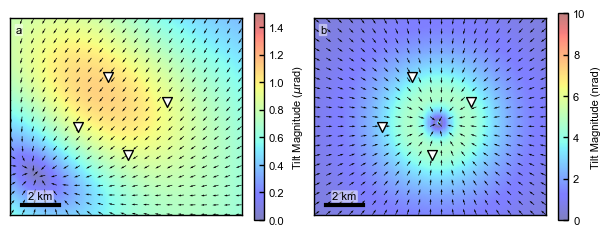

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6,2.25), constrained_layout=True)

# Yang
im = axs[0].pcolormesh(x, y, 1e6*np.sqrt(dxyang**2 + dyyang**2).reshape((len(x), len(y))), cmap="jet", alpha=.5, vmin=0, vmax=1.5, linewidth=0, rasterized=True)
yanglenq = np.sqrt(dxyangq**2 + dyyangq**2)
axs[0].quiver(gxq, gyq, dxyangq/yanglenq, dyyangq/yanglenq)
axs[0].set(xticks=[], yticks=[])
axs[0].set_aspect("equal")

# Seismometers
axs[0].scatter(
    stx[:-1],
    sty[:-1],
    marker="v",
    s=50,
    edgecolor="k",
    facecolor="w",
    zorder=2
)

# Scale bar
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()
bly = ymin + (0.05*(ymax-ymin))
blx = xmin + (0.05*(xmax-xmin))

for i in [0,1]:
    axs[i].plot([blx, blx+2e3], [bly, bly], linewidth=3)
    
    axs[i].text(
        blx+1e3,
        bly+200,
        "2 km",
        fontsize=8,
        horizontalalignment="center",
        verticalalignment="bottom",
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
    )

# Add label
axs[0].annotate(
    "a",
    (.025,.925),
    xycoords="axes fraction",
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)


# Nishimura
im1 = axs[1].pcolormesh(x, y, 1e9*np.sqrt(dxnish**2 + dynish**2).reshape((len(x), len(y))), cmap="jet", alpha=.5, vmin=0, vmax=10, linewidth=0, rasterized=True)
nishlenq = np.sqrt(dxnishq**2 + dynishq**2)
axs[1].quiver(gxq, gyq, dxnishq/nishlenq, dynishq/nishlenq)
axs[1].set(xticks=[], yticks=[])
axs[1].set_aspect("equal")

# Seismometers
axs[1].scatter(
    stx[:-1],
    sty[:-1],
    marker="v",
    s=50,
    edgecolor="k",
    facecolor="w",
    zorder=2
)

# Add label
axs[1].annotate(
    "b",
    (.025,.925),
    xycoords="axes fraction",
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

# Add colorbar
fig.colorbar(im, ax=axs[0], label="Tilt Magnitude ($\\mu$rad)")
fig.colorbar(im1, ax=axs[1], label="Tilt Magnitude (nrad)")

fig.savefig("figs/invert_example_tilt.pdf", bbox_inches="tight")